In [2]:
import numpy as np
import dill
import matplotlib.pyplot as plt
import matplotlib as mpl
import data_visualization as dv
from copy import deepcopy
import time
from pathlib import Path
import pandas as pd
from IPython.display import display
from scipy.stats import iqr
from scipy import stats
    
import read_data_functions as rdf
import plot_functions as pf
from Optimal_Stopping_Object import ModelConstructor
from initializer import InitialThangs
import Statistics as st
import loss_functions as lf

# import viper as vp
%load_ext autoreload
%autoreload 2
pd.set_option('display.max_columns', None)

# Select Exp1 or Exp2


In [3]:
EXPERIMENT = "Exp1"

# Initial Thangs


In [4]:
plt.style.reload_library()
plt.style.use('C:/Users/Seth Sullivan/anaconda3/Lib/site-packages/matplotlib/mpl-data/stylelib/cashaback_light.mplstyle')

In [5]:
AXES_LABELSIZE = 18
AXES_TITLESIZE = 22
XTICK_LABELSIZE = 15
YTICK_LABELSIZE = 15
FIGURE_TITLESIZE = 22
FONTSIZE = 15

mpl.rcParams['axes.labelsize'] = AXES_LABELSIZE
mpl.rcParams['axes.titlesize'] = AXES_TITLESIZE
mpl.rcParams['xtick.labelsize'] = XTICK_LABELSIZE
mpl.rcParams['ytick.labelsize'] = YTICK_LABELSIZE
mpl.rcParams['figure.titlesize'] = FIGURE_TITLESIZE
mpl.rcParams['font.size'] = FONTSIZE



wheel = dv.ColorWheel()

# Get path and save path 
LOAD_PATH = Path(f"D:\\OneDrive - University of Delaware - o365\\Subject_Data\\MatchPennies_Agent_{EXPERIMENT}")
SAVE_PATH = Path(rf"D:\OneDrive - University of Delaware - o365\Desktop\MatchPennies-Agent-Expirement\results\figures\sfn_poster")
it = InitialThangs(EXPERIMENT)

# Pickle Data and Models

In [6]:
if "group" not in locals():
    group = rdf.generate_subject_object_v3(EXPERIMENT, "All Trials", movement_metric_type='position')
else:
    if group.exp_info.experiment != EXPERIMENT:  # This means i changed experiment and need to run again
        group = rdf.generate_subject_object_v3(EXPERIMENT, "All Trials")
    
model_path = Path(f'D:\\OneDrive - University of Delaware - o365\\Desktop\\MatchPennies-Agent-Expirement\\results\\{EXPERIMENT}\\models')

model_description_dfs = list(model_path.glob(f"{EXPERIMENT}_model_descriptions*"))
model_parameter_dfs = list(model_path.glob(f"{EXPERIMENT}_model_parameters*"))
df_description = pd.read_pickle(model_description_dfs[-1])
df_params = pd.read_pickle(model_parameter_dfs[-1])
df_description['Parameters'] = np.where(df_description.isin([False,'Less','Greater']),1,0).sum(axis=1)
df_params['Parameters'] = np.where(df_description.isin([False,'Less','Greater']),1,0).sum(axis=1)


In [7]:
print(np.array(df_params.query('Model == "model240_2023_09_18_13_51_02"')['timing_sd']))

[]


In [8]:

# model_names_from_df = list(df_description.query('Parameters == 0 or (Known_Switch_SD==False and Known_Timing_SD==False and Parameters==2)')['Model'])
# model_names_from_df = list(df_description.query('Parameters == 0 or (Known_Switch_Delay==False and Parameters==1)')['Model'])
model_names_from_df = list(df_description.query('Parameters == 0')['Model'])
base_model_df = df_params[df_params['Model'].isin(model_names_from_df)]
base_model_df = base_model_df.sort_values('Parameters')
model_names = ['Theoretical Optimal', 'Theoretical Optimal\n(Not Accounting for Switch Delay)', "Blah", "Blah"]
display(base_model_df)
models = {}
for i, (index, row) in enumerate(base_model_df.iterrows()):
    model  = ModelConstructor(
        experiment=EXPERIMENT,
        num_blocks=row.num_blocks,
        num_timesteps=1800,
        agent_means=row.agent_means,
        agent_sds=row.agent_sds, #!
        reaction_time=row.reaction_time,
        movement_time=row.movement_time,
        reaction_sd=row.reaction_sd, #! Reducing these, aka the particiapnt thinks they are more certain than they are
        movement_sd=row.movement_sd,
        timing_sd=row.timing_sd,
        guess_switch_delay=row.guess_switch_delay, # Designed like this for broadcasting reasons
        guess_switch_sd=row.guess_switch_sd, # This includes electromechanical delay sd and timing sd bc it's straight from data
        # guess_sd=row.guess_sd,
        electromechanical_delay=row.electromechanical_delay,
        switch_cost_exists=True,
        expected=True,
        win_reward=row.win_reward,
        incorrect_cost=row.incorrect_cost,
        indecision_cost=row.indecision_cost,
        round_num = 23
    )
    print(model.inputs.guess_switch_sd)
    models.update({model_names[i]:model})

,Model,Loss,experiment,num_blocks,agent_means,agent_sds,nsteps,num_timesteps,round_num,expected,key,reaction_sd,movement_sd,timing_sd,guess_switch_sd,guess_sd,use_true_guess_sd,guess_sd_from_data,reaction_time,movement_time,guess_switch_delay,electromechanical_delay,guess_delay,win_reward,incorrect_cost,indecision_cost,prob_selecting_correct_target_reaction,prob_selecting_correct_target_guess,Parameters
4,model4_2023_09_26_15_25_09,10.821932,Exp1,6,"[[[999.306492462158], [1007.1201977157594], [1...","[[[48.76188568196375], [147.5029109578432], [4...",1,1800,20,True,1,"[[[37.69512147152565]], [[37.69512147152565]]]","[[[26.542679574365813]], [[26.542679574365813]]]","[[[76.61368327991575], [76.61368327991575], [7...","[[[112]], [[112]]]","[[[135.69692872616992], [135.69692872616992], ...",False,False,"[[[241.25]], [[241.25]]]","[[[157.25]], [[157.25]]]","[[[68]], [[68]]]","[[[50]], [[50]]]","[[[118]], [[118]]]",1.0,0.0,0.0,1.0,0.5,1


[[[112]]

 [[112]]]


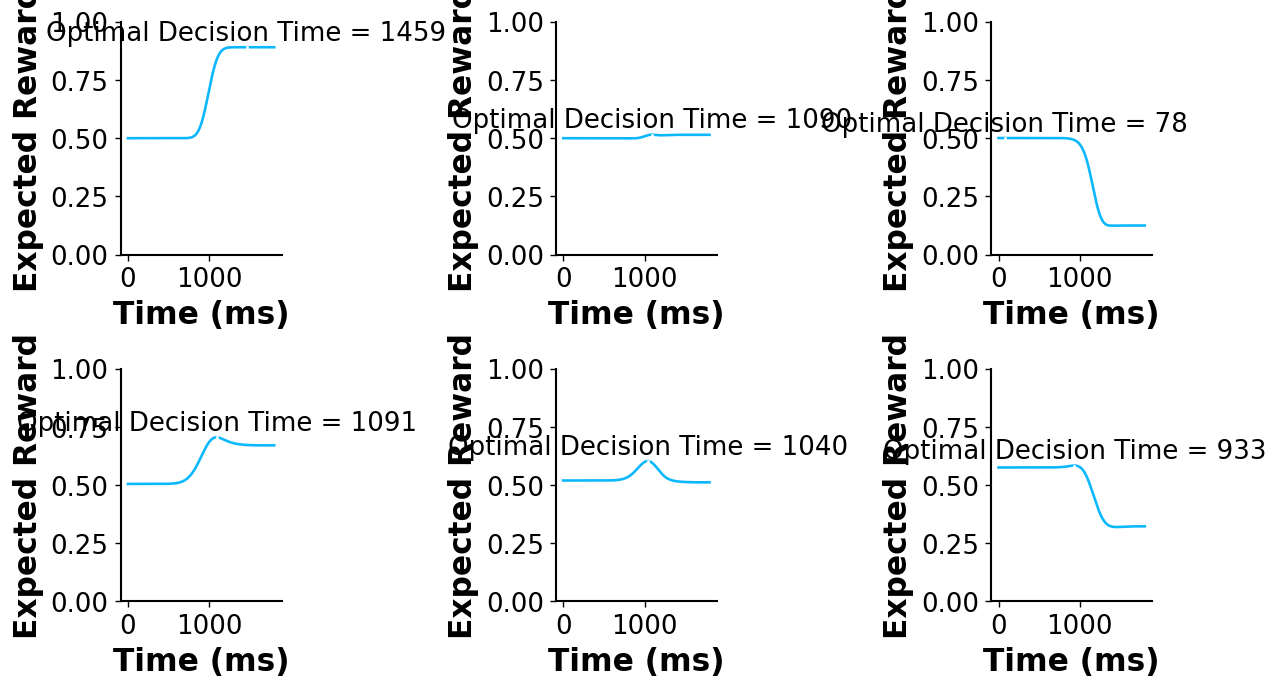

In [9]:
model.plot_optimals(['exp_reward'],titles=[None]*6,ylabel='Expected Reward',dpi=400,figsize=(10,6),)


## Plot Agent PDFs

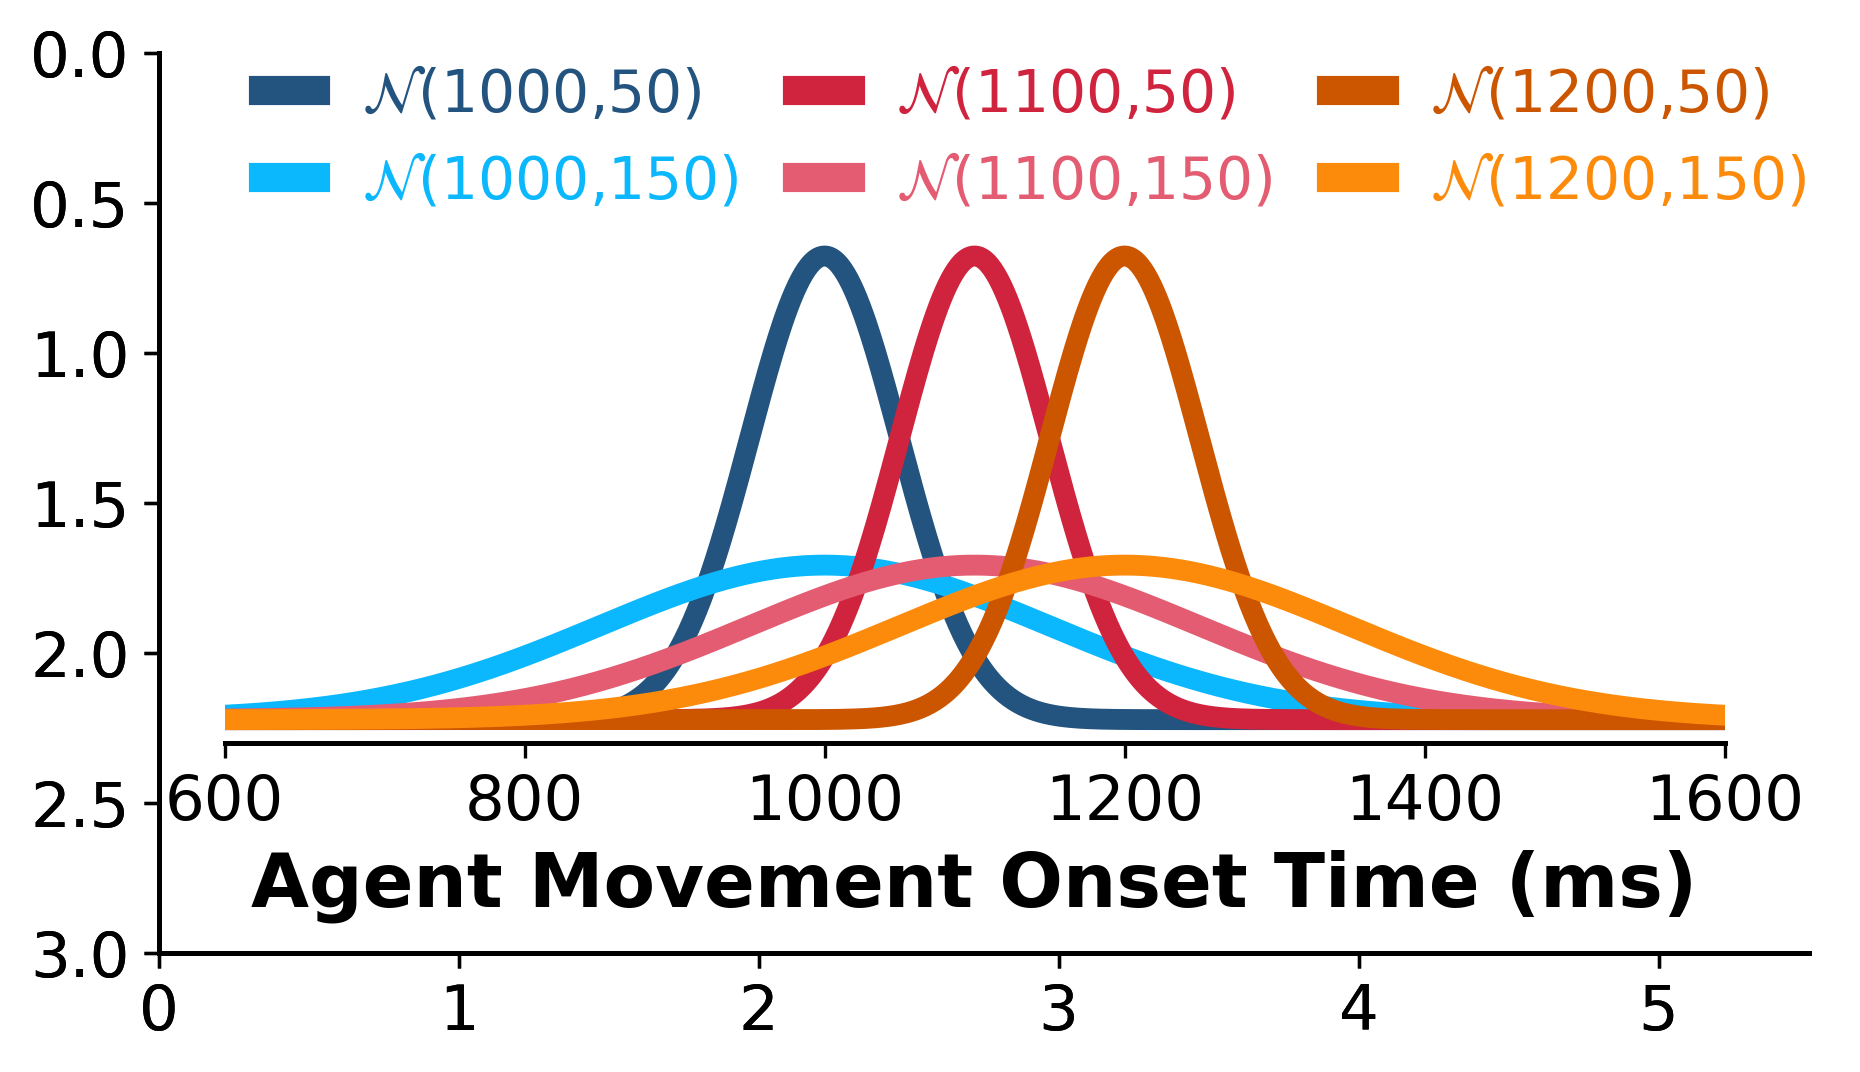

In [15]:
#
#* Plot Parameters
timesteps = np.arange(0,2000,1)
mu1,mu2,mu3 = 1000,1100,1200
sd1,sd2 = 50,150

dist1 = stats.norm.pdf(timesteps,mu1,sd1) 
dist2 = stats.norm.pdf(timesteps,mu1,sd2) 
dist3 = stats.norm.pdf(timesteps,mu2,sd1) 
dist4 = stats.norm.pdf(timesteps,mu2,sd2) 
dist5 = stats.norm.pdf(timesteps,mu3,sd1) 
dist6 = stats.norm.pdf(timesteps,mu3,sd2)
dists = [dist1, dist2, dist3, dist4, dist5, dist6]
colors = [
    wheel.prey_blue, wheel.rak_blue,
    wheel.lighten_color(wheel.rak_red,amount=1.4), wheel.lighten_color(wheel.rak_red,amount=1),
    wheel.lighten_color(wheel.burnt_orange,amount=1.0), wheel.rak_orange
]
legend_labels = [
    r'$\mathbf{\mu}$' + f' = {mu1}\n' + r'$\mathbf{\sigma}$' + f' = {sd1}', r'$\mathbf{\mu}$' + f' = {mu1}\n' + r'$\mathbf{\sigma}$' + f' = {sd2}',
    r'$\mathbf{\mu}$' + f' = {mu2}\n' + r'$\mathbf{\sigma}$' + f' = {sd1}', r'$\mathbf{\mu}$' + f' = {mu2}\n' + r'$\mathbf{\sigma}$' + f' = {sd2}',
    r'$\mathbf{\mu}$' + f' = {mu3}\n' + r'$\mathbf{\sigma}$' + f' = {sd1}', r'$\mathbf{\mu}$' + f' = {mu3}\n' + r'$\mathbf{\sigma}$' + f' = {sd2}',
]

legend_labels = [
    r'$\mathcal{N}$' + f'({mu1},{sd1})', r'$\mathcal{N}$' + f'({mu1},{sd2})',
    r'${\mathcal{N}}$' + f'({mu2},{sd1})', r'${\mathcal{N}}$' + f'({mu2},{sd2})',
    r'${\mathcal{N}}$' + f'({mu3},{sd1})', r'${\mathcal{N}}$' + f'({mu3},{sd2})'
]

#* All Plots
if True:
    fig = dv.Figure(figsize=(5.5,3),dpi= 300)
    ax = fig.add_panel((0.22, 0.6,
                        5.00, 1.7))
    
    for i in range(len(dists)):
        ax.plot(dists[i],color=colors[i],lw=5)
        
    dv.legend(ax,labels=legend_labels, colors=colors, ncols=3, loc=(0.01,1),
            handlelength=0.9, columnspacing=1,lw=7, fontsize=14, fontweight='light' )
    ax.set_xlim(600,1600)
    ax.get_yaxis().set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.set_xlabel('Agent Movement Onset Time (ms)',)

# fig.savefig(SAVE_PATH / 'agent_pdfs.png')

# Plot Distributions

Reaction Time Uncertainty

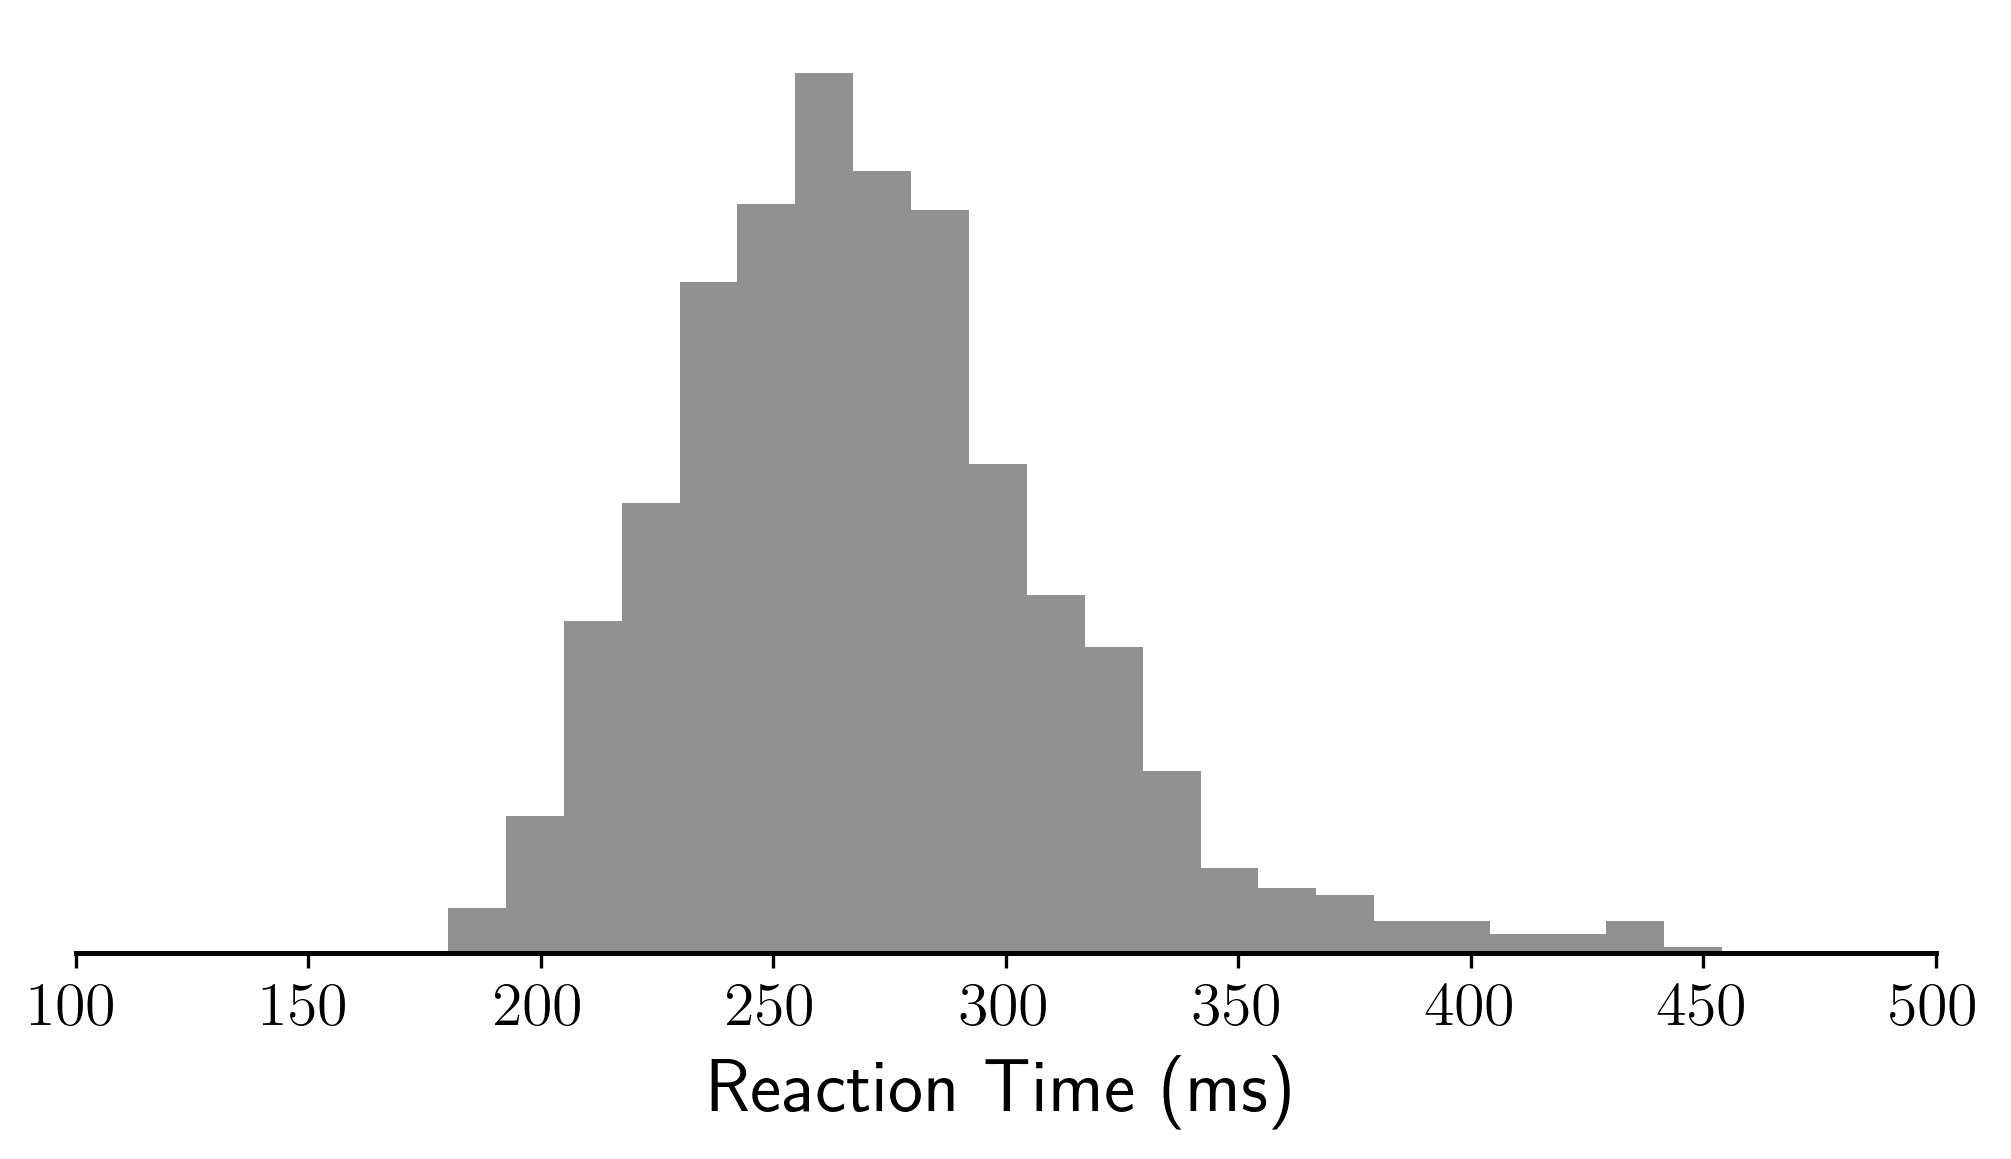

In [ ]:
fig,ax = plt.subplots(figsize = (8,4))
group.movement_metrics.get_reaction_times(filter_=False)
ax.hist(group.movement_metrics.reaction_times.flatten(),bins=40,color=wheel.grey)
# ax.axvline(np.nanmedian(group.movement_metrics.reaction_times.flatten()))
ax.set_xlabel('Reaction Time (ms)')
ax.set_yticks([])
ax.spines['left'].set_visible(False)
ax.set_xlim(100,500)
plt.show()

Movement Time Uncertainty

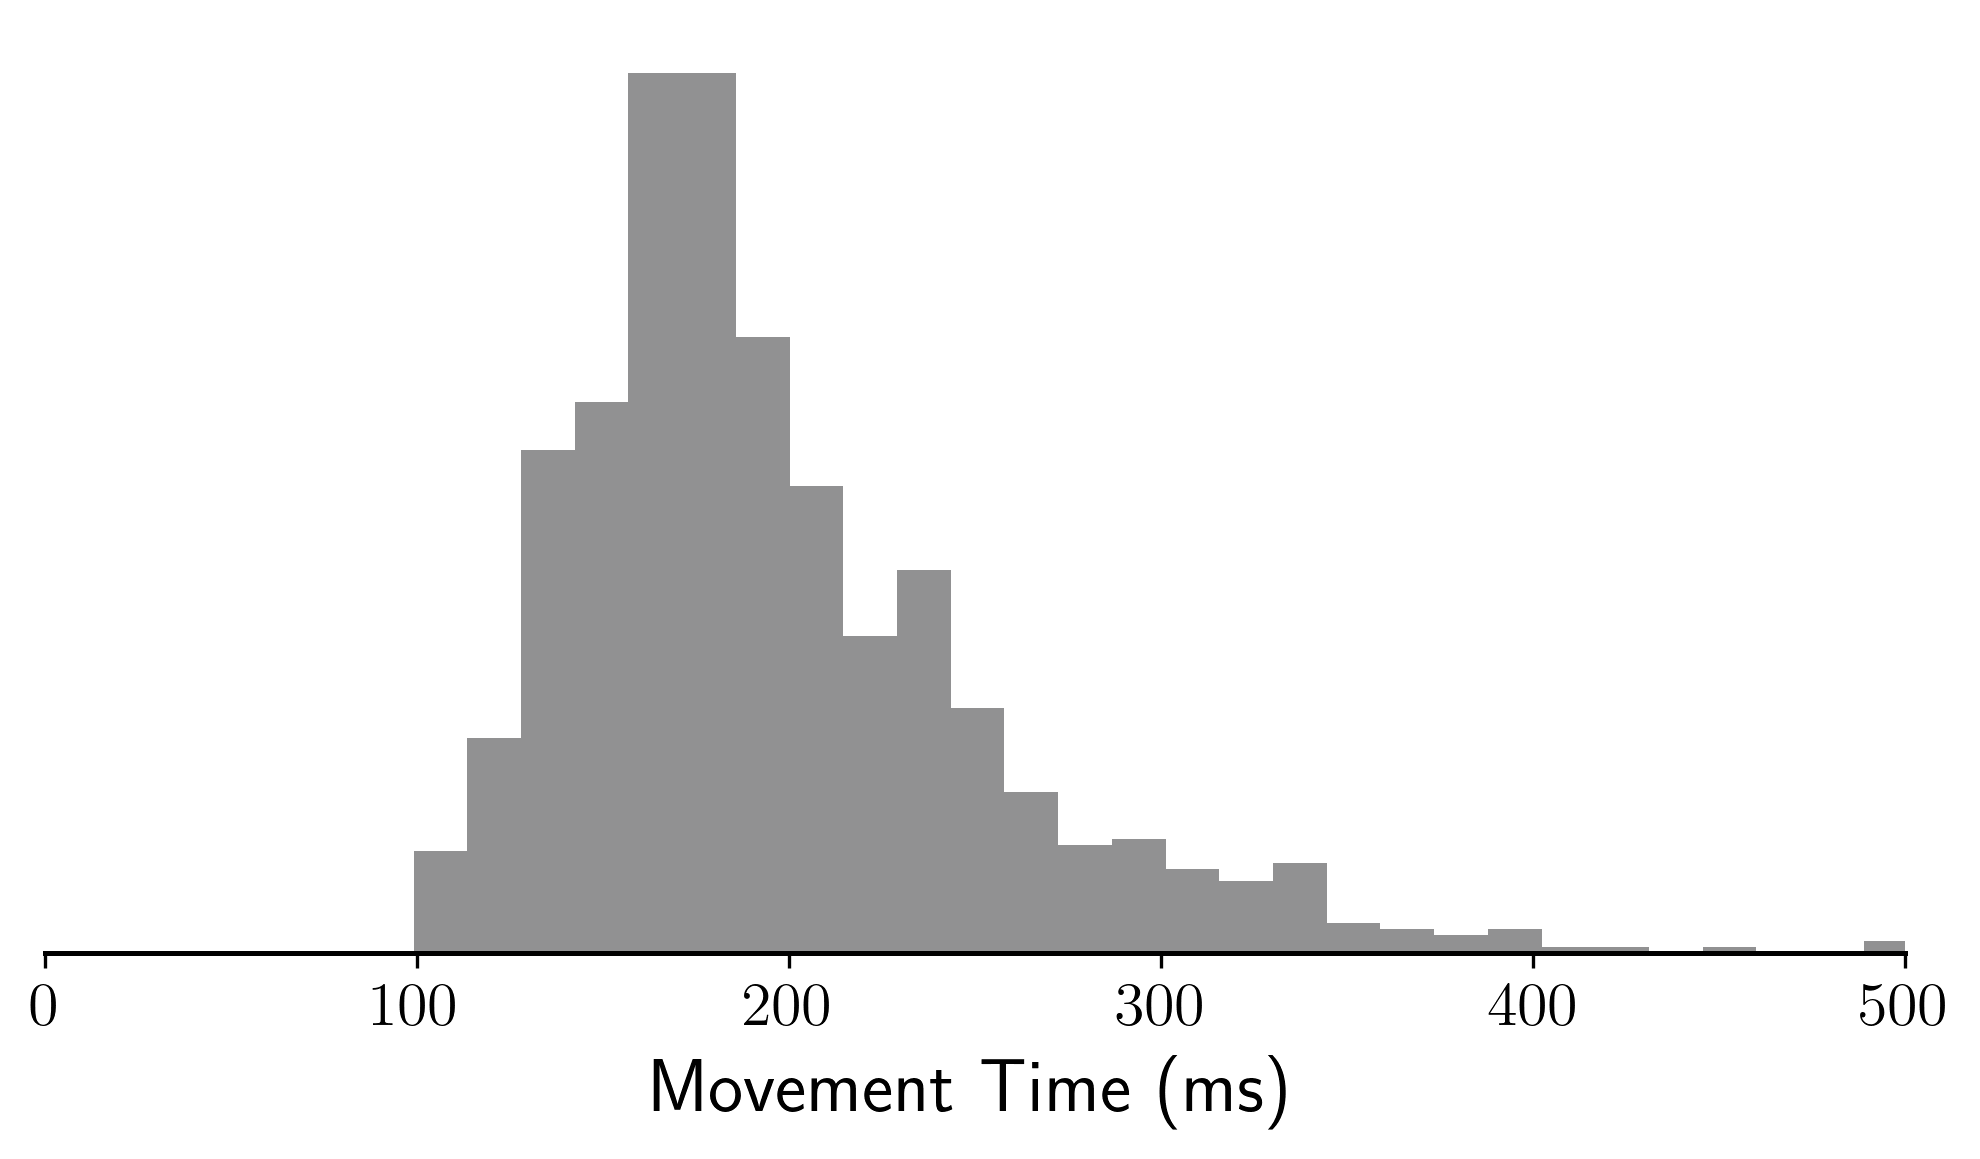

In [ ]:
fig,ax = plt.subplots(figsize = (8,4))
ax.hist(group.movement_metrics.movement_times('reaction').flatten(),bins=100,color=wheel.grey)
# ax.axvline(np.nanmedian(group.movement_metrics.reaction_times.flatten()))
ax.set_xlabel('Movement Time (ms)')
ax.set_yticks([])
ax.spines['left'].set_visible(False)
ax.set_xlim(0,500)
plt.show()

Decision Time Uncertainty

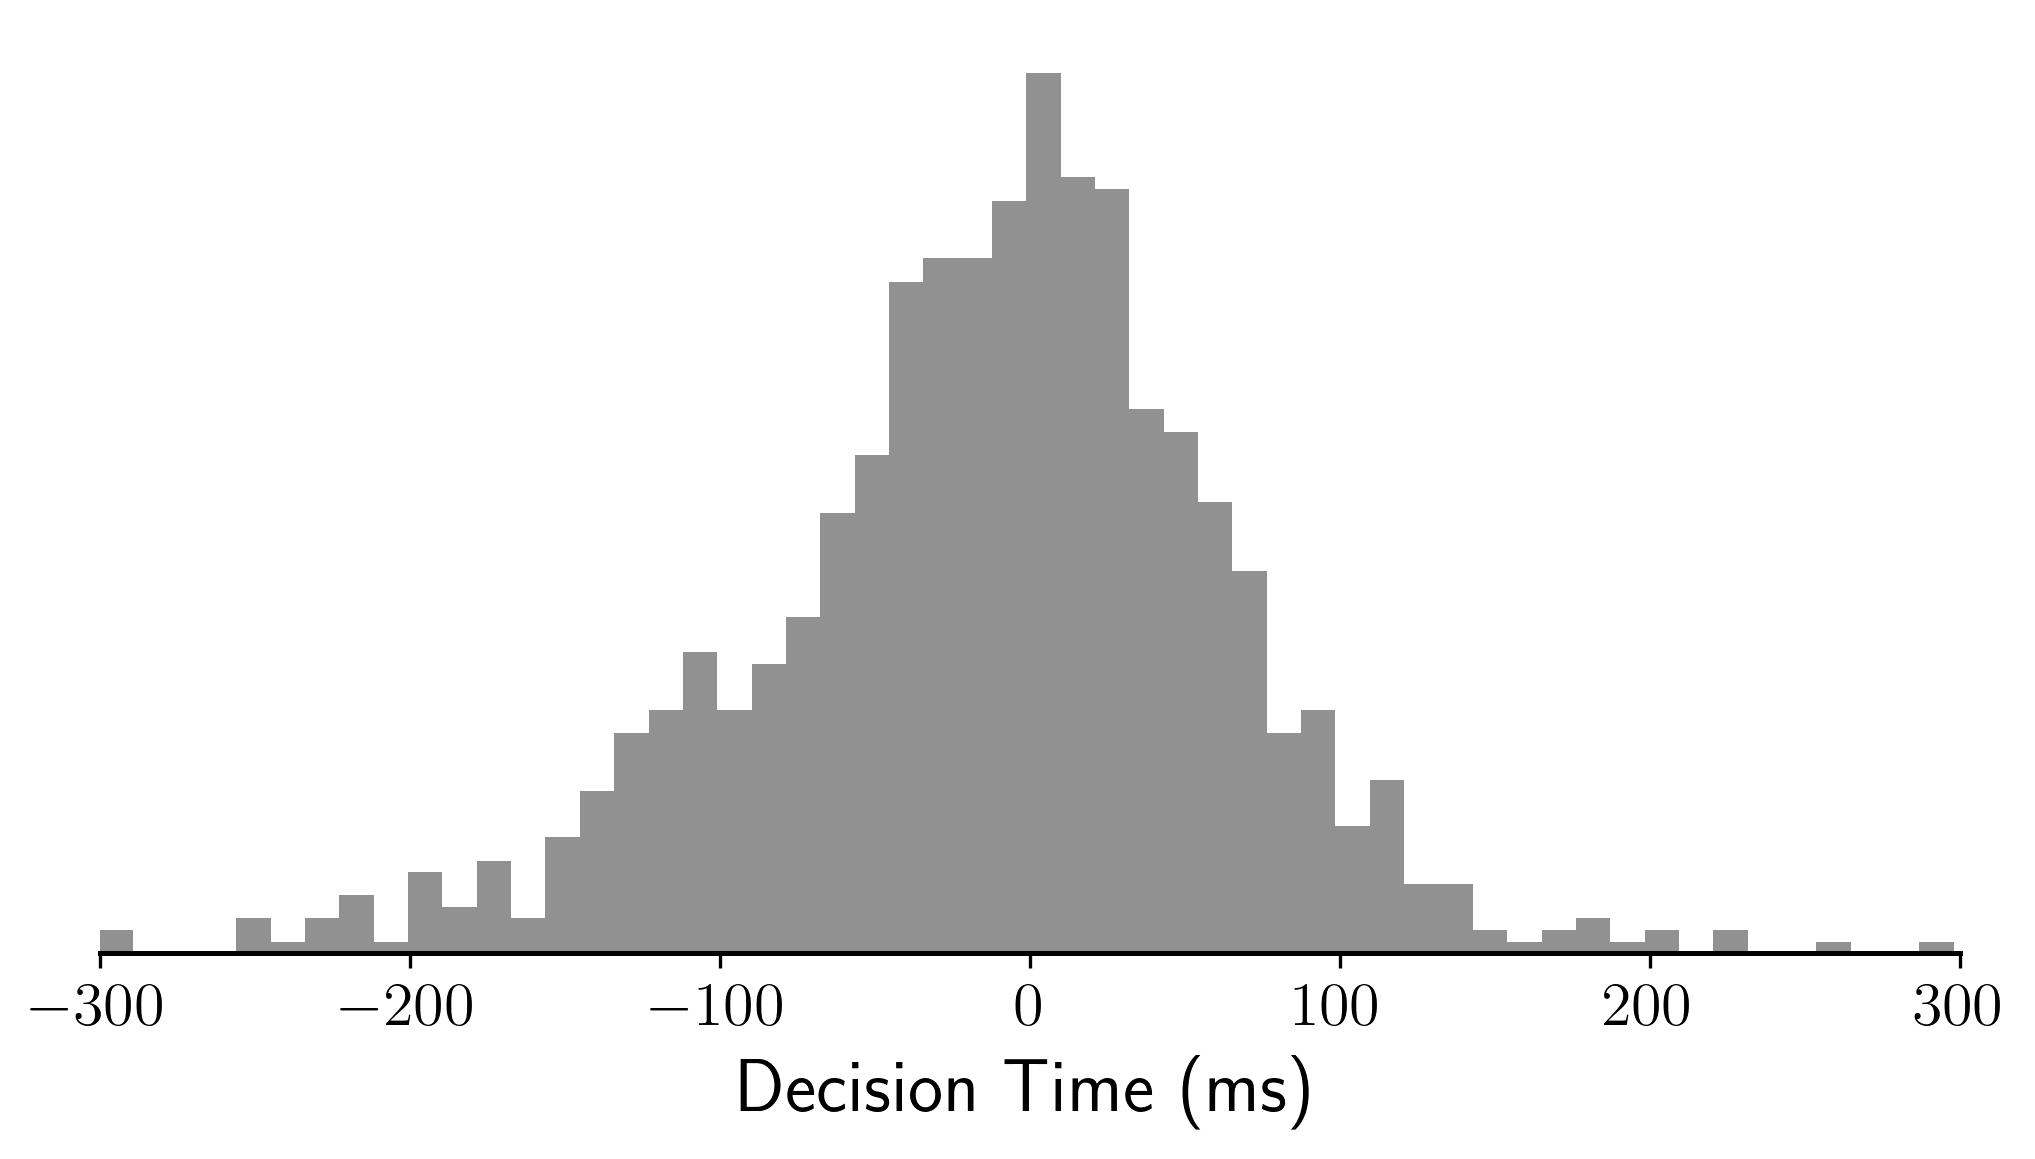

In [ ]:
fig,ax = plt.subplots(figsize = (8,4))
ax.hist(group.movement_metrics.coincidence_reach_time.flatten()-1500,bins=100,color=wheel.grey)
ax.set_xlabel('Decision Time (ms)')
# ax.set_ylabel('Counts')
ax.set_xlim(-300,300)
ax.set_yticks([])
ax.spines['left'].set_visible(False)
plt.show()

# Run Stats and Plot

In [ ]:
#
#* Set plot constants
SHOW_BOXPLOTS = True
SHOW_MODELS = True
SHOW_STATS = True
w,h = 13,8
bw = (0.35*w)/it.num_blocks # box widths of all boxes combined takes up 30% of the width
xlocs = np.linspace(0, w/2 - 0.5, num=len(it.trial_block_titles))
legend_fontsize = 18
title_fontsize = 35
#* Get dataframe and create the stats inputs
df = st.generate_dataframe(group, EXPERIMENT, DROP_SUBJECT_NUM=None)
# display(df)

stats_inputs = st.Inputs(
    df, experiment = EXPERIMENT, num_subjects = len(df['Subject'].unique()), 
    num_blocks=it.num_blocks,num_trials=it.num_trials,
    trial_block_titles=it.trial_block_titles,xlab=it.xlabel,
    f1_xticklabels=it.f1_collapse_xticklabs,f2_xticklabels=it.f2_collapse_xticklabs,
    f1_xlabel=it.f1_xlabel,f2_xlabel=it.f2_xlabel,
    M = 1e7
)

!! DROPPING SUBJECT None !! 


c:\Users\Seth Sullivan\anaconda3\envs\aim1\lib\site-packages\numpy\lib\nanfunctions.py:1218: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


## Median Movement Onset 

### Stats

In [ ]:
median_movement_onset_anova = st.Anova('Median_Movement_Onset_Time', stats_inputs)
display(median_movement_onset_anova.anova)
median_movement_onset_boot = st.Bootstrap(stats_inputs, median_movement_onset_anova,
                                          no_collapse=True, alternative='variable', test='median')
median_movement_onset_statistics = median_movement_onset_boot.run_bootstrap()
median_movement_onset_statistics

,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,ng2,eps
0,Factor_1,59699.487500,2,38,29849.743750,4.360600,0.019730,0.030075,0.031095,0.775649
1,Factor_2,66811.602083,1,19,66811.602083,6.815716,0.017188,0.017188,0.034671,1.000000
2,Factor_1 * Factor_2,2723.429167,2,38,1361.714583,0.521157,0.598016,0.565215,0.001462,0.828255


Significant interaction, doing pairwise bootstraps for each condition...


[{'02': 0.0,
  '04': 0.4372832,
  '13': 0.5019298,
  '15': 0.5019298,
  '24': 0.02229,
  '35': 0.4378881},
 {'02': 70.0, '04': 65.0, '13': 75.0, '15': 50.0, '24': 60.0, '35': 65.0}]

### Plot

In [ ]:


if True:
    metric = st.df_to_array(df['Median_Movement_Onset_Time'],stats_inputs.num_subjects, stats_inputs.num_blocks)
    metric2 = np.nanmean(group.movement_metrics.movement_onset_times('task'),axis=2)
    ylocs = np.arange(0, 1751, 250)
    ylabel = 'Movement Onset Time (ms)'
    
    fig = dv.Figure(figsize=(w, h), dpi=300)
    ax = fig.add_panel(dim=(1.5, 1., w - 2, h -2))
    model_data = [model.results.get_metric(model.player_behavior.wtd_leave_time,
                                           metric_type='true',decision_type='optimal') for model in models.values()]
    pf.multi_boxplot(ax,metric2,xlocs)
    pf.multiple_models_boxplot(
            ax=ax,
            data=metric,
            box_width = bw,
            model_data=model_data,
            show_boxplot=SHOW_BOXPLOTS,
            show_models=SHOW_MODELS,
            reorder_xaxis = True,
            labels=['Theoretical Optimal', 'Not Accounting for\nGuess Uncertainty'],
            colors=wheel.grey,
            linestyles=None,
            line_colors = [wheel.green, wheel.rak_blue],
            xlocs=xlocs,
            # xtick_locs = np.linspace(1, w/div_w - 0.5, num=len(it.trial_block_titles)),
            ylocs=ylocs,
            xticklabels=it.trial_block_titles,
            xlabel=it.xlabel,
            ylabel=ylabel,
            legend_fontsize=legend_fontsize,
            legend_loc='upper right',
            title_padding=40,
    )
    ax.title.set_size(title_fontsize)
    ax.xaxis.label.set_size(AXES_LABELSIZE)
    ax.set_ylim(0,1750)
    ax.set_xlim(-1,max(xlocs)+1)
    if SHOW_STATS:
        pf.plot_stats(
            ax,stats_inputs=stats_inputs, 
            statistics=median_movement_onset_statistics,
            combos = ['02','24','04',],xlocs=xlocs, 
            xloc_index = ['01','12','02',], 
            ypos=[1425,1480,1590 ,1420,1490],
            fontsize=18,stacked=True,
            show_effectsize=False,
        )
    plt.show()
# fig.savefig(SAVE_PATH / 'median_movement_onset_time')

KeyboardInterrupt: 

## Indecisions

In [ ]:
indecisions_anova = st.Anova('Indecisions', stats_inputs)
display(indecisions_anova.anova)
indecisions_boot = st.Bootstrap(stats_inputs, indecisions_anova,no_collapse=True,alternative='two-sided')
indecisions_statistics = indecisions_boot.run_bootstrap()
indecisions_statistics

,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,ng2,eps
0,Factor_1,2481.432292,2,38,1240.716146,10.003995,0.000323,0.000528,0.111388,0.910429
1,Factor_2,132.825521,1,19,132.825521,1.017642,0.325754,0.325754,0.006665,1.000000
2,Factor_1 * Factor_2,1216.432292,2,38,608.216146,5.577994,0.007515,0.013381,0.057891,0.785547


Significant interaction, doing pairwise bootstraps for each condition...


[{'02': 0.000255,
  '04': 0.0039415000000000006,
  '13': 0.132884,
  '15': 1.0,
  '24': 1.0,
  '35': 0.5925924},
 {'02': 85.0,
  '04': 80.0,
  '13': 62.5,
  '15': 57.49999999999999,
  '24': 60.0,
  '35': 65.0}]

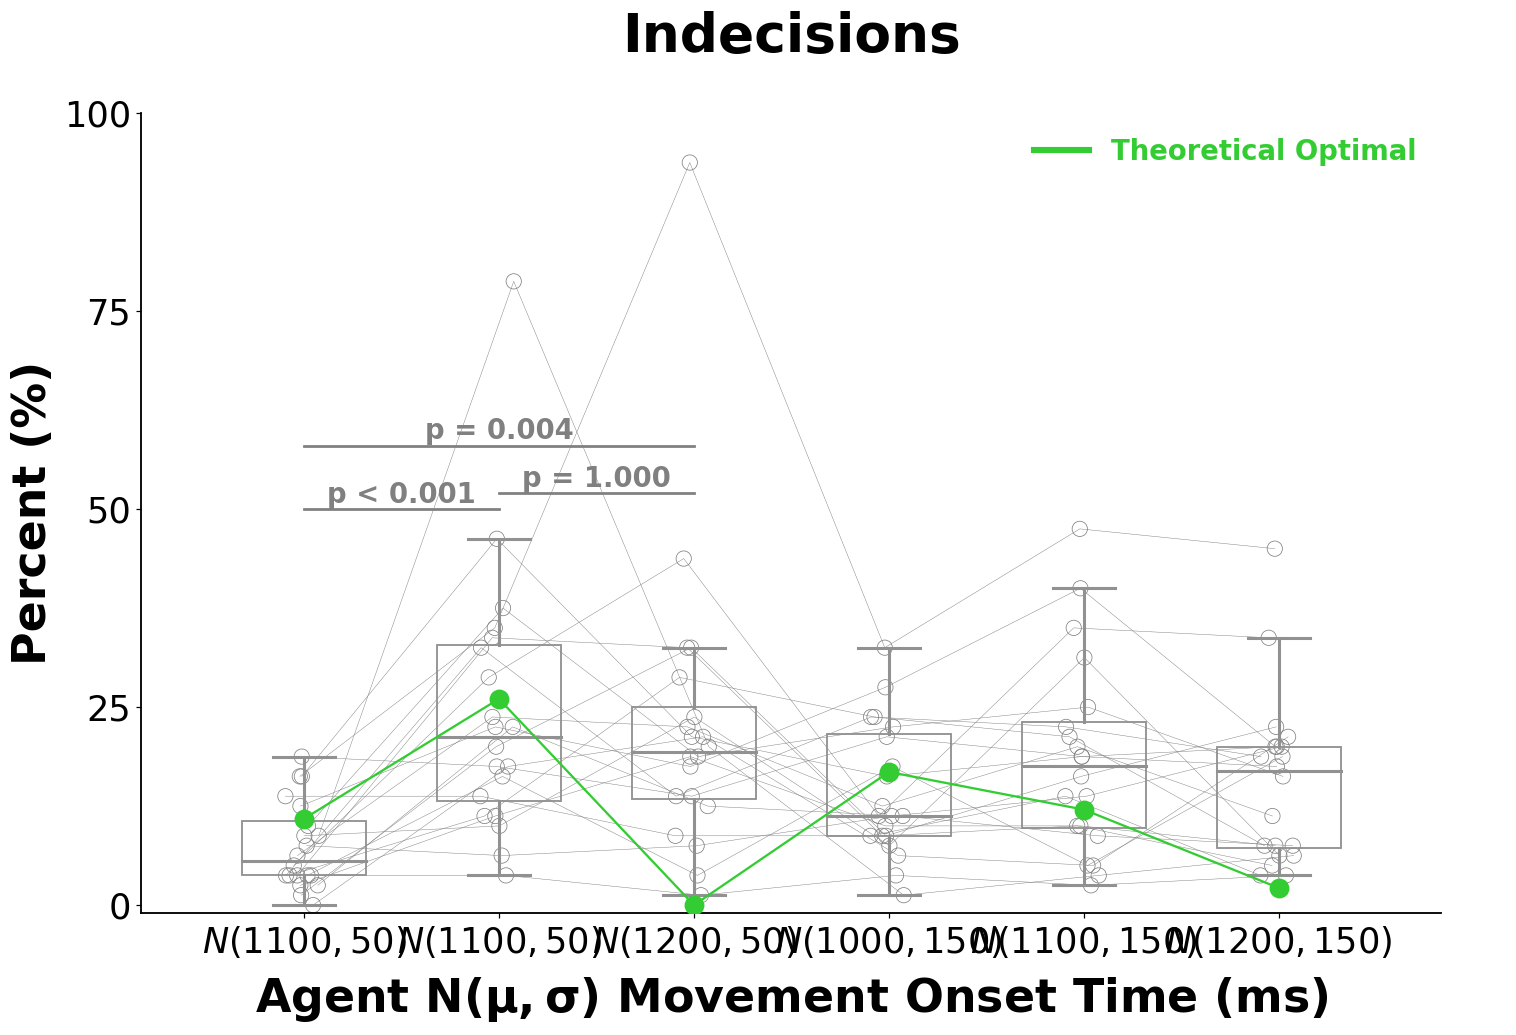

In [ ]:
if True:
    metric = st.df_to_array(df['Indecisions'],stats_inputs.num_subjects, stats_inputs.num_blocks)
    ylocs = np.arange(0, 101, 25)
    ylabel = 'Percent (%)'
    title = 'Indecisions' 

    fig = dv.Figure(figsize=(w, h), dpi=110)
    ax = fig.add_panel(dim=(0.6, 0, w / div_w, h / div_h))
    model_data = [model.results.get_metric(model.score_metrics.prob_indecision, metric_type='true',decision_type='optimal')*100 for model in models.values()]
    pf.multiple_models_boxplot(
            ax=ax,
            data=metric,
            box_width = bw,
            model_data=model_data,
            show_boxplot=SHOW_BOXPLOTS,
            show_models=SHOW_MODELS,
            reorder_xaxis = True,
            labels=['Theoretical Optimal', 'Not Accounting for\nGuess Uncertainty'],
            colors=wheel.grey,
            linestyles=None,
            line_colors = [wheel.green, wheel.rak_blue],
            xlocs=xlocs,
            ylocs=ylocs,
            xticklabels=it.trial_block_titles,
            xlabel=it.xlabel,
            ylabel=ylabel,
            title=title,
            legend_fontsize=legend_fontsize,
            title_fontsize=title_fontsize,
            title_padding=40,
        )
    ax.set_ylim(-1,100)
    ax.set_xlim(-1,max(xlocs)+1)
    if SHOW_STATS:
        pf.plot_stats(
            ax,stats_inputs=stats_inputs, statistics=indecisions_statistics,
            combos = ['02','24','04',],xlocs=xlocs, 
            xloc_index = ['01','12','02',], 
            ypos=[50,52,58,1420,1490],
            fontsize=18,stacked=True,
            show_effectsize=False
        )
    
    fig.remove_figure_borders()


## SD Movement Onset

### Stats

In [ ]:
sd_movement_onset_anova = st.Anova('SD_Movement_Onset_Time', stats_inputs)
display(sd_movement_onset_anova.anova)
sd_movement_onset_boot = st.Bootstrap(stats_inputs, sd_movement_onset_anova,no_collapse=True,
                                          alternative='two-sided',test='median')
sd_movement_onset_statistics = sd_movement_onset_boot.run_bootstrap()
sd_movement_onset_statistics

,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,ng2,eps
0,Factor_1,15203.650706,2,38,7601.825353,5.501936,0.007971,0.018015,0.041648,0.691673
1,Factor_2,10047.983589,1,19,10047.983589,20.361034,0.000238,0.000238,0.027919,1.000000
2,Factor_1 * Factor_2,3851.588749,2,38,1925.794374,2.485900,0.096694,0.097401,0.010889,0.988805


Significant interaction, doing pairwise bootstraps for each condition...


[{'02': 0.008828,
  '04': 0.000264,
  '13': 0.5017998,
  '15': 0.5017998,
  '24': 0.005901,
  '35': 0.1616865},
 {'02': 65.0, '04': 90.0, '13': 60.0, '15': 65.0, '24': 80.0, '35': 60.0}]

### Plot

0.7583333333333333


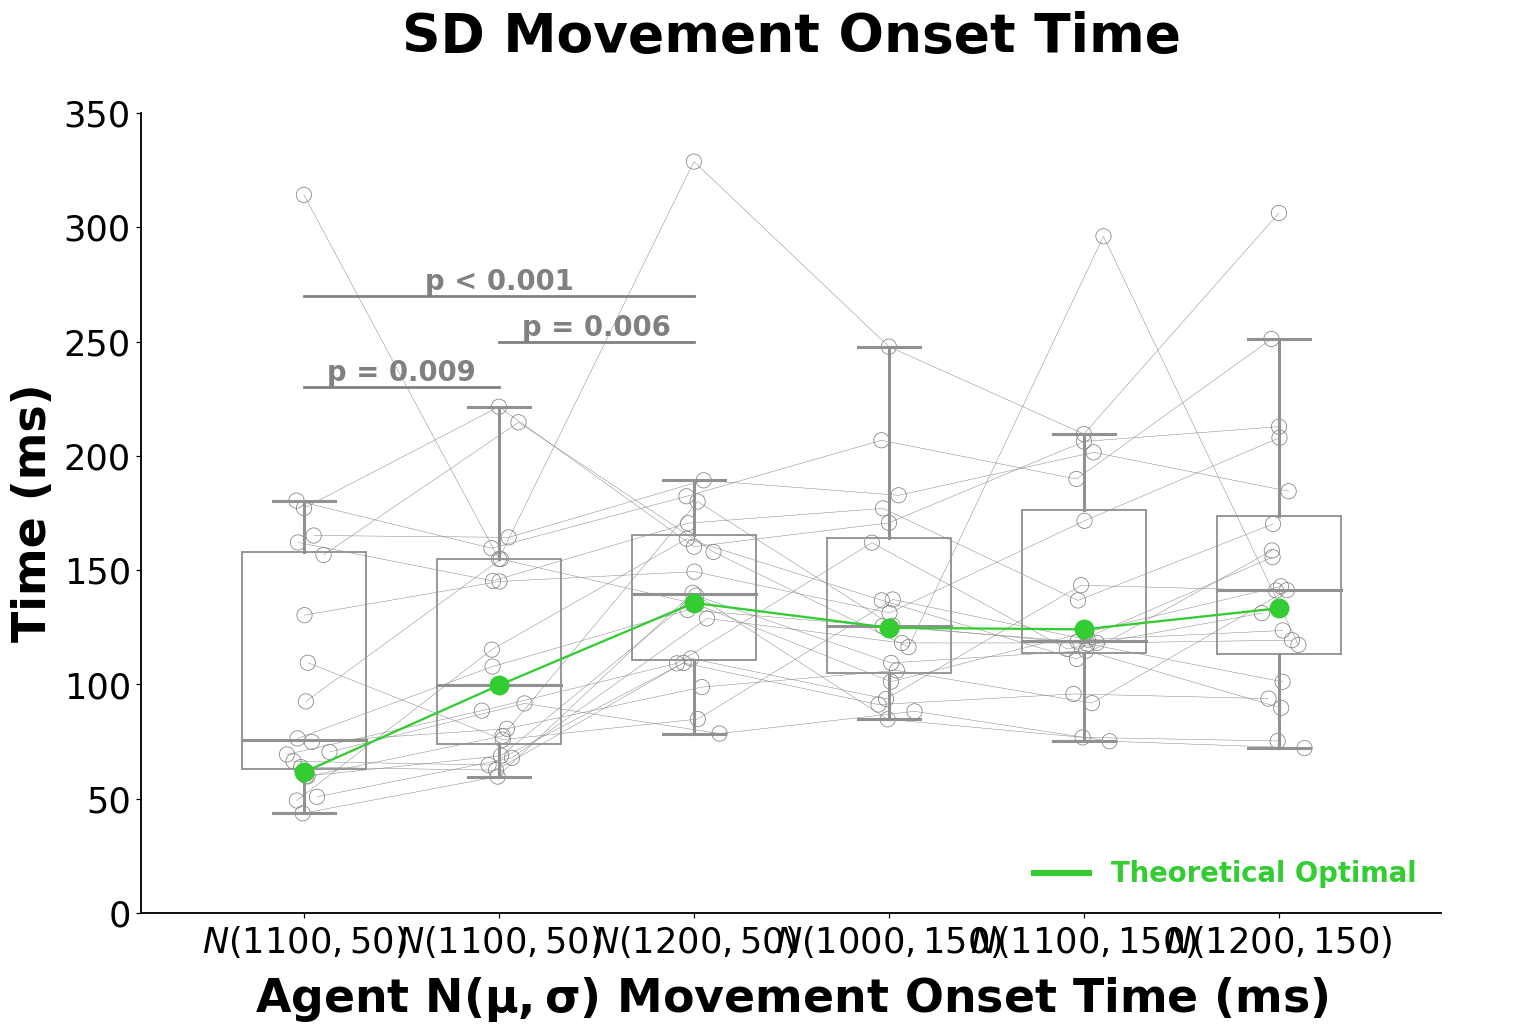

In [ ]:


if True:
    metric = st.df_to_array(df['SD_Movement_Onset_Time'],stats_inputs.num_subjects, stats_inputs.num_blocks)
    ylocs = np.arange(0, 400, 50)
    ylabel = 'Time (ms)'
    title = 'SD Movement Onset Time' 

    fig = dv.Figure(figsize=(w, h), dpi=110)
    ax = fig.add_panel(dim=(0.6, 0, w / div_w, h / div_h))
    model_data = [model.results.get_metric(model.player_behavior.wtd_leave_time_sd,
                                           metric_type='true',decision_type='optimal') for model in models.values()]
    pf.multiple_models_boxplot(
            ax=ax,
            data=metric,
            box_width = bw,
            model_data=model_data,
            show_boxplot=SHOW_BOXPLOTS,
            show_models=SHOW_MODELS,
            reorder_xaxis = True,
            labels=['Theoretical Optimal', 'Not Accounting for\nGuess Uncertainty'],
            colors=wheel.grey,
            linestyles=None,
            line_colors = [wheel.green, wheel.rak_blue],
            xlocs=xlocs,
            # xtick_locs = np.linspace(1, w/div_w - 0.5, num=len(it.trial_block_titles)),
            ylocs=ylocs,
            xticklabels=it.trial_block_titles,
            xlabel=it.xlabel,
            ylabel=ylabel,
            title=title,
            legend_fontsize=legend_fontsize,
            legend_loc='lower right',
            title_fontsize=title_fontsize,
            title_padding=40,
        )
    ax.set_ylim(0,350)
    ax.set_xlim(-1,max(xlocs)+1)
    if SHOW_STATS:
        pf.plot_stats(ax,stats_inputs=stats_inputs, statistics=sd_movement_onset_statistics,
                    combos = ['02','04','24'],xlocs=xlocs, 
                    xloc_index = ['01','02','12'], 
                    ypos=[230,270,250,],
                    fontsize=18,stacked=True,
                    show_effectsize=False,
                        )
    
    fig.remove_figure_borders()
print(bw)